In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import sklearn.linear_model
import sklearn.model_selection
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import load_iris

/Users/lisitsyn/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Applied Machine Learning

## Classification, and decision trees

### Recap

- We came to some kind of general framework: select your loss function, select your model, then optimize
- We mostly talked about linear models and regression losses

### Classification

- The naïve loss function we could choose is 1/0
- We miss if our prediction is wrong (1 for dog predicted as cat)
- Everything is just perfect otherwise 
- There is a problem with that

### Geometry of classification

Let's consider two blobs

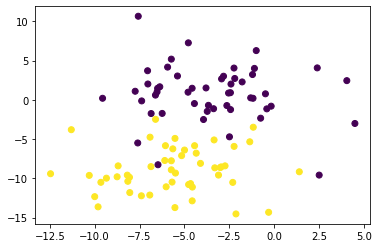

In [2]:
X, y = make_blobs(n_samples=100, centers=2, random_state=17, cluster_std=3.0)
plt.scatter(X[:, 0], X[:, 1], c=y);

### Geometry of classification

Let's project the data using a hyperplane

In [3]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(max_iter=1000, tol=1e-9).fit(X, y)
xx, yy = np.meshgrid(np.linspace(-10, 0, 100), np.linspace(-15, 5, 100))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

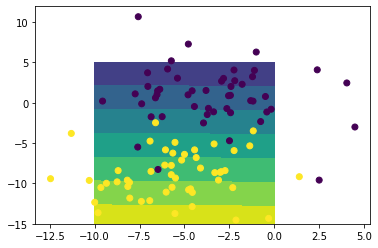

In [4]:
plt.contourf(xx, yy, Z.reshape(xx.shape));
plt.scatter(X[:, 0], X[:, 1], c=y);

### Geometry of classification

The projection makes 1/0 loss obvious

In [5]:
def project(model, data):
    return (np.dot(data, model.coef_.T) + model.intercept_).ravel()

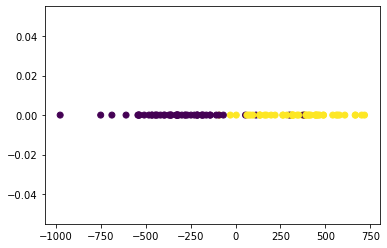

In [6]:
plt.scatter(project(clf, X), np.zeros_like(y), c=y);

### 1/0 loss

In case of negative (-1) class

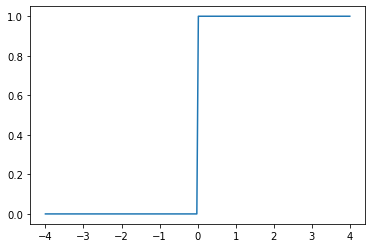

In [7]:
xs = np.linspace(-4, 4, 200); y_true = -1.0
plt.plot(xs, xs > 0.0);

### Surrogate loss

- Optimizing 1/0 is infeasible
- It is even NP-hard as it is reducible to satisfiability problem
- In simpler words: you don't know how to change the weights to make it better
- We need an approximation

### Logistic loss

The loss of `LogisticRegression`

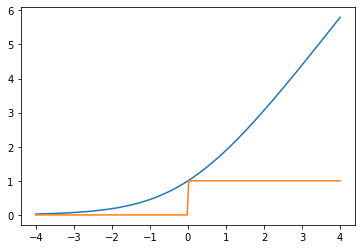

In [4]:
xs = np.linspace(-4, 4, 200); y_true = -1.0
plt.plot(xs, np.log2(1.0 + np.exp(-y_true*xs)));
plt.plot(xs, xs > 0.0);

### Hinge loss

(linear) SVM = Hinge Loss + L2

The loss of `LinearSVC`

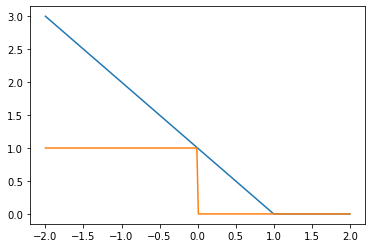

In [9]:
xs = np.linspace(-2, 2, 200); y_true = +1.0
plt.plot(xs, np.maximum(0.0, 1.0 - y_true*xs));
plt.plot(xs, xs < 0.0);

### The choice of loss

- You can't know for sure
- Logistic loss will lead to better probability estimation
- Logistic loss might have worse accuracy
- Hinge loss might have better accuracy

### Multiclass problems

- Not all the problems we have are binary
- Happily, we can reduce them to binary subproblems
- The usual strategy is One vs Rest (OvR)

### One versus Rest

- For any $K$-class problem we construct $K$ classifiers
- Each classifier $K_i$ tries to tell the $i$-th class from the rest
- To predict, we compare outputs of each classifier
- e.g. cars vs rest 0.9, birds vs rest 0.8, ...
- The classifier with the highest confidence wins

### Standartization

- The usual approach to standartize your features is to subtract the mean and divide by the std
- Important if regularization is used (popular interview question)
- Useful for linear models, neural networks, and distance-based models

In [10]:
data = load_iris()['data']
print(data[0, :])
data[:, 0] = (data[:, 0] - data[:, 0].mean()) / data[:, 0].std()
data[:, 1] = (data[:, 1] - data[:, 1].mean()) / data[:, 1].std()
print(data[0, :])

[5.1 3.5 1.4 0.2]
[-0.90068117  1.01900435  1.4         0.2       ]


### Missing data handling

- Real data could have missing values
- One approach is to drop the missing data (columns/rows)
- Dropping rows is usually a bad idea
- In linear models replacing with zero is not a good idea
- Linear models would tolerate replacing with mean/median

### Count features

- Most counts are Poisson- or exponentially distributed
- They have 'long tails' model **have to** adapt to

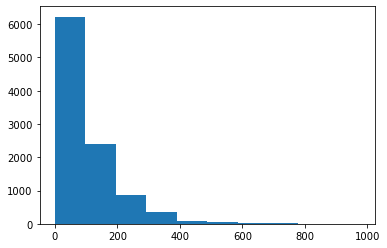

In [11]:
sample = np.random.exponential(scale=100.0, size=10000)
plt.hist(sample);

### Count features

- Counts are usually transformed using `log` or `sqrt`
- This squashes the tail

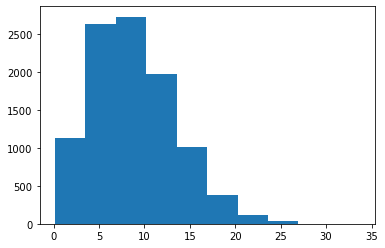

In [12]:
sample = np.random.exponential(scale=100.0, size=10000)
plt.hist(np.sqrt(sample));

### Feature engineering

- Linear models 'like' it more when the features are gaussian-like
- Your goal is to put all the knowledge about the domain into the representation
- Even good model is useless on bad features

Let's check the Adult dataset

In [13]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### Splitting

- One way to engineer a feature
- Does it help to work hard?
- We need a measure

In [14]:
df['hard.working'] = (df['hours.per.week'] > 45)

### Entropy

The measure of disorder, $- \sum_i p_i \log_2 p_i $

In [15]:
df['income'].value_counts(normalize=True)

<=50K    0.75919
>50K     0.24081
Name: income, dtype: float64

### Entropy

The measure of disorder, $- \sum_i p_i \log_2 p_i $

In [16]:
ps = np.array(df['income'].value_counts(normalize=True))
ps, np.log2(ps), ps * np.log2(ps)

(array([0.75919044, 0.24080956]),
 array([-0.39746626, -2.05403544]),
 array([-0.30175259, -0.49463137]))

In [17]:
- sum(ps * np.log2(ps))

0.7963839552022132

### Entropy after the split

In [18]:
ps = np.array(df[df['hard.working'] == True]['income'].value_counts(normalize=True))
df[df['hard.working'] == True]['income'].value_counts(normalize=True), - sum(ps * np.log2(ps)) * (df['hard.working'] == True).mean()


(<=50K    0.582435
 >50K     0.417565
 Name: income, dtype: float64,
 0.2149313830244384)

In [19]:
ps = np.array(df[df['hard.working'] == False]['income'].value_counts(normalize=True))
df[df['hard.working'] == False]['income'].value_counts(normalize=True), - sum(ps * np.log2(ps)) * (df['hard.working'] == False).mean()

(<=50K    0.808827
 >50K     0.191173
 Name: income, dtype: float64,
 0.5495846223757777)

### Information gain

- The difference between entropies tells us something
- We had some entropy before the split
- We've got some entropy after the split
- The information we gain is difference between these entropies

### Decision tree

- We can split a few times
- This forms a tree of different conditions
- In the leafs of this tree we make a final decision

In [20]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('adult.csv', index_col=0)
df.fillna(inplace=True, value=-1.0)
df = df.apply(LabelEncoder().fit_transform)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
dt.fit(df.drop(columns='income'), df.income)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

In [21]:
df[df.columns[4]]

age
90    6
82    6
66    6
54    0
41    5
     ..
22    4
27    2
40    2
58    6
22    4
Name: marital.status, Length: 32561, dtype: int64

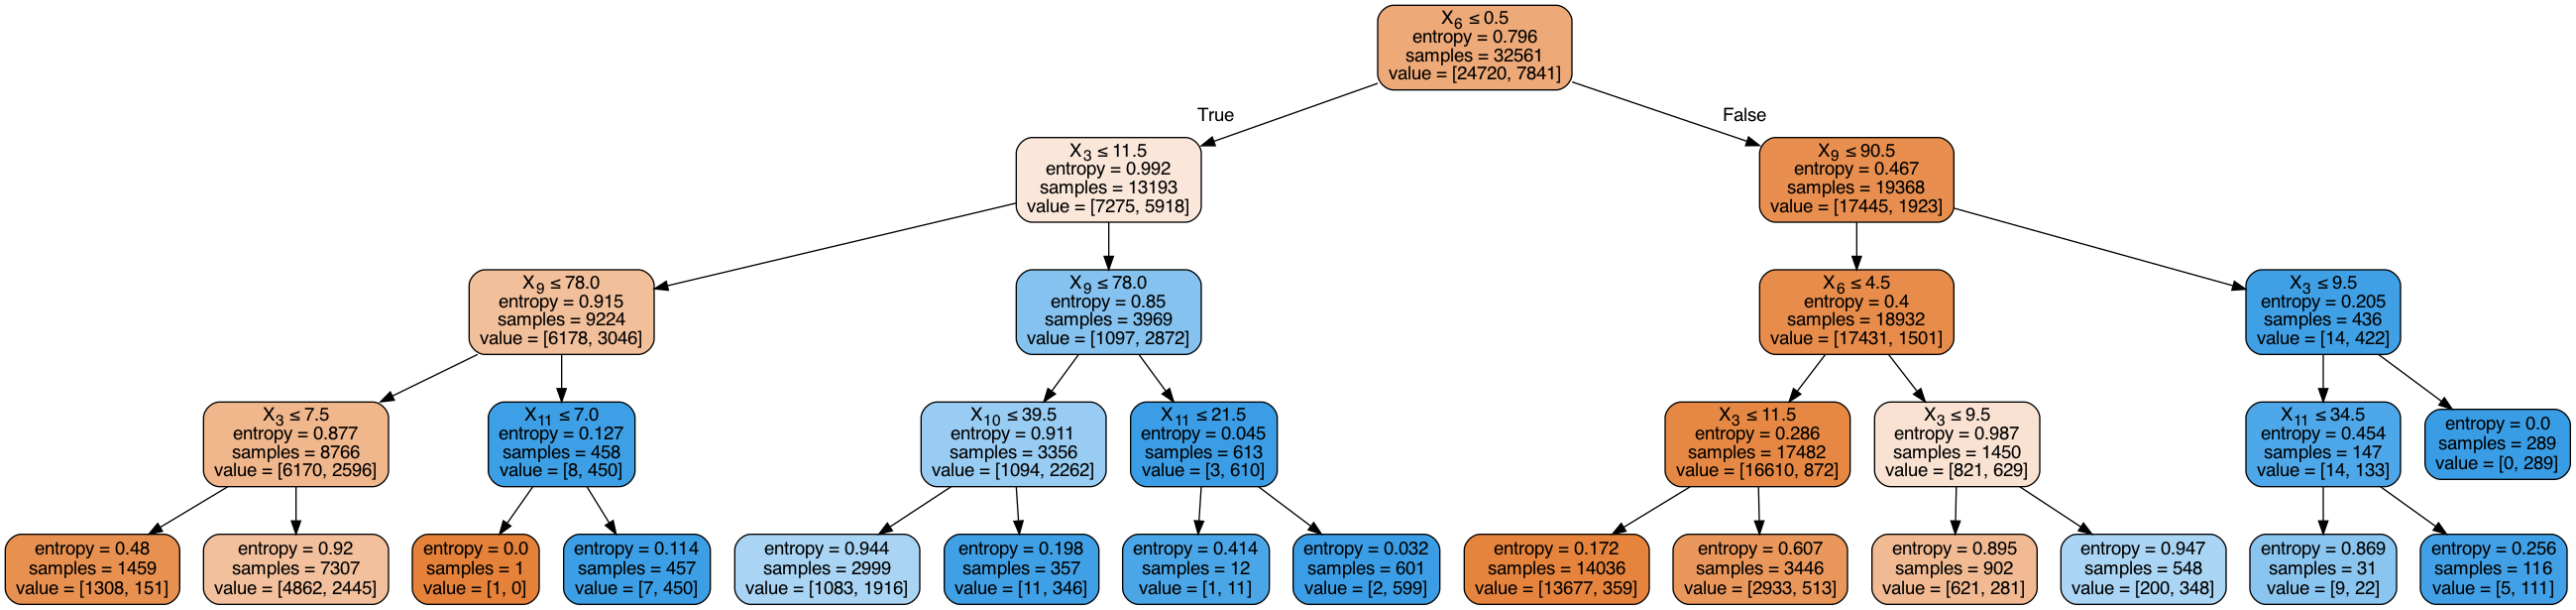

In [22]:
Image(graph.create_png())

### ID3 algorithm

One of the first algorithm to train decision trees

- Choose the split based on information gain (and do not reuse it anymore)
- Create a node with the split
- Recurse on children nodes made by the split

ID3 is a greedy algorithm as the problem is NP-hard, again

### Further development

Details are in:
- Splitting continuous variables
- Choosing the right split (entropy is not the only way)
- Combining a few splits at the time
- etc etc etc

This led to CART, C4.5, C5.0 and many other algorithms

### Notes

- Decision trees are quite versatile, any features are fine
- Missing data can be happily replaced by -1 (or any other non-existent value)
- No obvious loss/objective function we minimize directly

### In Python

In [23]:
from sklearn.tree import DecisionTreeClassifier
df = pd.read_csv('cs-training.csv', index_col=0)
df.fillna(inplace=True, value=-1.0)
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(df.drop(columns='SeriousDlqin2yrs'), df.SeriousDlqin2yrs)

DecisionTreeClassifier(criterion='entropy')

### Overfitting

- Decision trees are quite prone to overfitting due to their exponential nature
- Play Akinator to check you don't need many questions to guess the very concrete person
- We need to regularize them, too

### Regularization, again

- The simplest measure of complexity of a tree is its depth
- Minimize error with minimal possible depth
- Other ways include limiting the minimal numbers of examples in a leaf

### Next time

- Other ways to fight overfitting
- Ensembling methods
- Boosting and bagging

### Self-assessment

1. What loss you'd expect to be more tolerant to some noise in your data? *a) hinge loss b) logistic loss c) 1/0 loss*
2. Your colleague doesn't want to mess with feature scaling. To prove him wrong you remind they of... *a) gradient descent b) regularization c) loss functions*
3. You've found a split that increases the entropy in one part and decreases in the other one. You... *a) discard that split b) use that split c) do something else*
4. Decision trees seem to be superior of linear models. *Is it true and why?*
5. Multi-class problems seem to be easier with linear models. *Is it true and why?*